# OptNet/qpth Attacks Exploration

*Expanded from [Brandon Amos](https://bamos.github.io) and [J. Zico Kolter](http://zicokolter.com/).*


This notebook is based on the example from [qpth](https://github.com/locuslab/qpth). Documentation from the library is available [here](http://locuslab.github.io/qpth)

## Setup and Dependencies

+ Python/numpy/[PyTorch](https://pytorch.org)
+ [qpth](https://github.com/locuslab/qpth):
  *Our fast QP solver for PyTorch released in conjunction with this paper.*
+ [bamos/block](https://github.com/bamos/block):
  *Our intelligent block matrix library for numpy, PyTorch, and beyond.*
+ Optional: [bamos/setGPU](https://github.com/bamos/setGPU):
  A small library to set `CUDA_VISIBLE_DEVICES` on multi-GPU systems.

In [ ]:
!pip install matplotlib qpth block

You will need to modify the `qpth` library to support weird updates. In particular, lines 83-84 in `/lib/site-packages/qpth` would need to be commented out for the attack on non-PSD `Q` matrices to work.

In [1]:
import torch

import torch.nn as nn
from torch.autograd import Function, Variable
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from qpth.qp import QPFunction

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

# Define the model

+ We'll be using a network architecture that looks like:

```
FC-ReLU-(BN)-FC-ReLU-(BN)-QP-softmax
```

where the QP OptNet layer learns the coefficients `Q`, `q`, `G`, and `h` for
a QP with inequality constraints:

```
z_{i+1} = argmin_z 0.5 z^T Q z + q^t z
          s.t. Gz <= h
```

In [34]:
class OptNet(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, bn, nineq=200, neq=0, eps=1e-4):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.bn = bn
        self.nCls = nCls
        self.nineq = nineq
        self.neq = neq
        self.eps = eps

        # Normal BN/FC layers.
        if bn:
            self.bn1 = nn.BatchNorm1d(nHidden)
            self.bn2 = nn.BatchNorm1d(nCls)

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nCls * nCls)
        self.fc3 = nn.Linear(nCls * nCls, nCls)

        # QP params.
        self.M = Variable(torch.tril(torch.ones(nCls, nCls)))
        self.p = Parameter(torch.ones(nCls))
        self.G = Parameter(torch.Tensor(nineq,nCls).uniform_(-1,1))
        self.z0 = Parameter(torch.zeros(nCls))
        self.s0 = Parameter(torch.ones(nineq))

    def forward(self, x):
        nBatch = x.size(0)

        # Normal FC network.
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Set up the qp parameters Q=LL^T and h = Gz_0+s_0.
        # L is a lower triangular matrix
        L = self.M * torch.tril(x.reshape(nBatch, nCls, nCls)).mean(axis=0)
        Q = L.mm(L.t()) + self.eps*Variable(torch.eye(self.nCls))
        h = self.G.mv(self.z0)+self.s0
        e = Variable(torch.Tensor())
        x_t = F.relu(self.fc3(x))
        x = QPFunction(verbose=-1)(Q, x_t, self.G, h, e, e)

        return F.log_softmax(x)

In [41]:
class NonPSDOptNet(nn.Module):
    def __init__(self, nFeatures, nHidden, nCls, bn, nineq=200, neq=0, eps=1e-4):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden = nHidden
        self.bn = bn
        self.nCls = nCls
        self.nineq = nineq
        self.neq = neq
        self.eps = eps

        # Normal BN/FC layers.
        if bn:
            self.bn1 = nn.BatchNorm1d(nHidden)
            self.bn2 = nn.BatchNorm1d(nCls)

        self.fc1 = nn.Linear(nFeatures, nHidden)
        self.fc2 = nn.Linear(nHidden, nCls * nCls)
        self.fc3 = nn.Linear(nCls * nCls, nCls)

        # QP params.
        self.M = Variable(torch.tril(torch.ones(nCls, nCls)))
        self.p = Parameter(torch.ones(nCls))
        self.G = Parameter(torch.Tensor(nineq,nCls).uniform_(-1,1))
        self.z0 = Parameter(torch.zeros(nCls))
        self.s0 = Parameter(torch.ones(nineq))

    def forward(self, x):
        nBatch = x.size(0)

        # Normal FC network.
        x = x.view(nBatch, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Set up the qp parameters Q=Q(z_i) and h = Gz_0+s_0.
        Q = self.M.mm(self.M.t()) * x.reshape(nBatch, nCls, nCls).mean(axis=0) + self.eps*Variable(torch.eye(self.nCls))
        h = self.G.mv(self.z0)+self.s0
        e = Variable(torch.Tensor())
        x_t = F.relu(self.fc3(x))
        x = QPFunction(verbose=-1)(Q, x_t, self.G, h, e, e)

        return F.log_softmax(x)

# Attacks on PSD

+ Create random data for a regression task and then optimize the parameters with Adam.
+ Run for an OptNet where Q is derived from previous layer (but ensures PSD of matrices)
+ Run for unrestricted OptNet where Q is derived from the previous layer

In [16]:
# Create random data
nBatch, nFeatures, nHidden, nCls = 16, 20, 20, 2
x = Variable(torch.randn(nBatch, nFeatures), requires_grad=False)
y = Variable((torch.rand(nBatch) < 0.5).long(), requires_grad=False)

In [35]:
# Initialize the model.
model = OptNet(nFeatures, nHidden, nCls, bn=False)
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print('Iteration {}, loss = {:.2f}'.format(t, loss.data))
    losses.append(loss.data)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the zloss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

torch.Size([16, 4])
torch.Size([2, 2])


\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, loss = 0.82
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 1, loss = 0.82
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 2, loss = 0.82
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 3, loss = 0.78
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 4, loss = 0.81
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 5, loss = 0.83
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 6, loss = 0.77
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 7, loss = 0.81
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 8, loss = 0.81
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 9, loss = 0.77
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 10, loss = 0.83
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 11, loss = 0.80
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 12, loss = 0.80
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 13, loss = 0.80
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 14, loss = 0.80
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 15, loss = 0.80
torch.Siz

Iteration 126, loss = 0.77
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 127, loss = 0.77
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 128, loss = 0.77
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 129, loss = 0.76
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 130, loss = 0.76
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 131, loss = 0.76
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 132, loss = 0.74
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 133, loss = 0.74
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 134, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 135, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 136, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 137, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 138, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 139, loss = 0.75
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 140, loss = 0.74
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 

Iteration 251, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 252, loss = 0.57
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 253, loss = 0.57
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 254, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 255, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 256, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 257, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 258, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 259, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 260, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 261, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 262, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 263, loss = 0.55
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 264, loss = 0.56
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 265, loss = 0.55
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 

Iteration 376, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 377, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 378, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 379, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 380, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 381, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 382, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 383, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 384, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 385, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 386, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 387, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 388, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 389, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 390, loss = 0.46
torch.Size([16, 4])
torch.Size([2, 2])
Iteration 

(0.0, 0.8529702916741371)

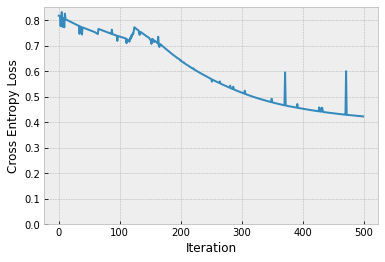

In [36]:
plt.plot(losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylim(ymin=0.)

In [42]:
# Initialize the model.
model = NonPSDOptNet(nFeatures, nHidden, nCls, bn=False)
loss_fn = torch.nn.CrossEntropyLoss()

# Initialize the optimizer.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    print('Iteration {}, loss = {:.2f}'.format(t, loss.data))
    losses.append(loss.data)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

\anaconda3\envs\layers\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 0, loss = 0.82
Iteration 1, loss = 0.82
Iteration 2, loss = 0.81
Iteration 3, loss = 0.81
Iteration 4, loss = 0.81
Iteration 5, loss = 0.81
Iteration 6, loss = 0.80
Iteration 7, loss = 0.80
Iteration 8, loss = 0.80
Iteration 9, loss = 0.80
Iteration 10, loss = 0.80
Iteration 11, loss = 0.80
Iteration 12, loss = 0.80
Iteration 13, loss = 0.80
Iteration 14, loss = 0.79
Iteration 15, loss = 0.79
Iteration 16, loss = 0.79
Iteration 17, loss = 0.79
Iteration 18, loss = 0.79
Iteration 19, loss = 0.79
Iteration 20, loss = 0.79
Iteration 21, loss = 0.78
Iteration 22, loss = 0.78
Iteration 23, loss = 0.78
Iteration 24, loss = 0.78
Iteration 25, loss = 0.78
Iteration 26, loss = 0.78
Iteration 27, loss = 0.78
Iteration 28, loss = 0.78
Iteration 29, loss = 0.77
Iteration 30, loss = 0.77
Iteration 31, loss = 0.77
Iteration 32, loss = 0.77
Iteration 33, loss = 0.77
Iteration 34, loss = 0.77
Iteration 35, loss = 0.77
Iteration 36, loss = 0.77
Iteration 37, loss = 0.76
Iteration 38, loss = 0

Iteration 308, loss = 0.86
Iteration 309, loss = 0.85
Iteration 310, loss = 0.85
Iteration 311, loss = 0.85
Iteration 312, loss = 0.85
Iteration 313, loss = 0.86
Iteration 314, loss = 0.85
Iteration 315, loss = 0.85
Iteration 316, loss = 0.79
Iteration 317, loss = 0.72
Iteration 318, loss = 0.77
Iteration 319, loss = 0.75
Iteration 320, loss = 0.85
Iteration 321, loss = 0.84
Iteration 322, loss = 0.84
Iteration 323, loss = 0.84
Iteration 324, loss = 0.82
Iteration 325, loss = 0.84
Iteration 326, loss = 0.86
Iteration 327, loss = 0.84
Iteration 328, loss = 0.84
Iteration 329, loss = 0.83
Iteration 330, loss = 0.81
Iteration 331, loss = 0.83
Iteration 332, loss = 0.83
Iteration 333, loss = 0.83
Iteration 334, loss = 0.83
Iteration 335, loss = 0.83
Iteration 336, loss = 0.83
Iteration 337, loss = 0.82
Iteration 338, loss = 0.82
Iteration 339, loss = 0.82
Iteration 340, loss = 0.82
Iteration 341, loss = 0.82
Iteration 342, loss = 0.81
Iteration 343, loss = 0.81
Iteration 344, loss = 0.78
I

(0.0, 1.0544403880834579)

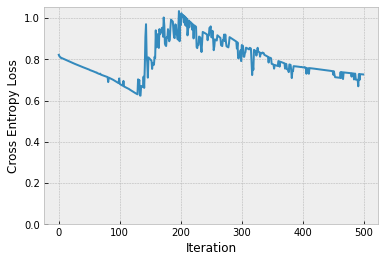

In [43]:
plt.plot(losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration')
plt.ylim(ymin=0.)